July 4, 2022 - Exploring scipy.signal's ways to approximate a given frequency response (freq.-domain filter) via a finite impulse response (FIR) filter. See Word journal, week27 MON.

In [88]:
import numpy as np
import pandas as pd

currdir = 'U:/py/sounds-phd/97_tests/05_dsp_related/20220704_fir_design'
# Load example freq.-domain (FD) filter
wi = pd.read_csv(f'{currdir}\\sampleFilt_i.csv').to_numpy()
wr = pd.read_csv(f'{currdir}\\sampleFilt_r.csv').to_numpy()
w = wr[:, 1] + 1j * wi[:, 1]    # target frequency response

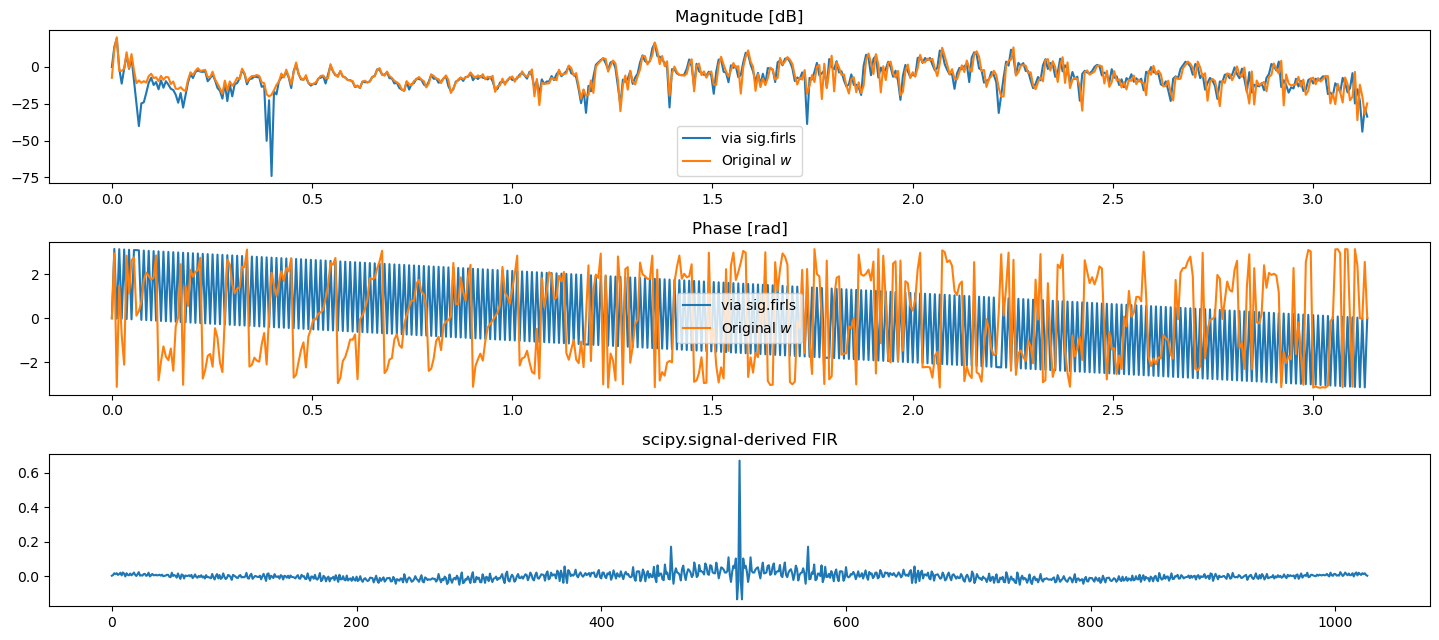

In [89]:
import scipy.signal as sig
import copy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures background

n = len(w)  # num. filter taps
fs = 16000

f = np.arange(n+1) / n * fs / 2
deltaf = f[1] - f[0]
bands = np.zeros(2 * n)
for ii in range(len(f)):
    bands[(2 * ii):(2 * ii + 2)] = f[ii] - deltaf / 2
bands[bands < 0] = 0

bands = copy.copy(f)
gains = np.abs(w)# / np.amax(np.abs(w))
desired = np.append(gains, gains[-1])


myfir = sig.firls(numtaps=2 * n + 1,
            bands=bands,
            desired=desired,
            fs=fs)

# sig.remez

# import scipy
# myfir = scipy.fft.ifftshift(myfir)
            
freq, response = sig.freqz(myfir)

fig, axes = plt.subplots(3,1)
fig.set_size_inches(14.5, 6.5)
axes[0].plot(freq, 20 * np.log10(np.abs(response)), label='via sig.firls')
axes[0].plot(freq, 20 * np.log10(np.abs(w[:-1])), label='Original $w$')
axes[0].legend()
axes[0].set_title('Magnitude [dB]')
axes[1].plot(freq, np.angle(response), label='via sig.firls')
axes[1].plot(freq, np.angle(w[:-1]), label='Original $w$')
axes[1].legend()
axes[1].set_title('Phase [rad]')
axes[2].plot(myfir)
axes[2].set_title('scipy.signal-derived FIR')
plt.tight_layout()

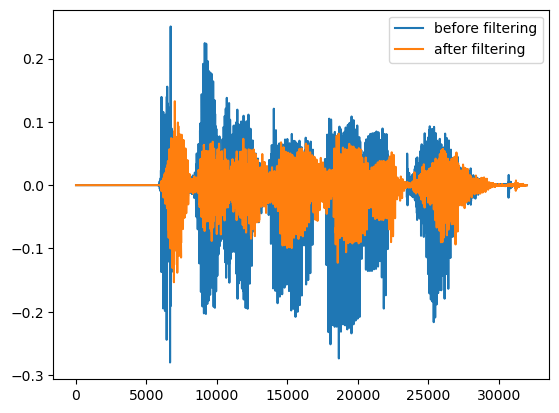

In [90]:
# Apply scipy.signal-constructed linear-phase IR to a signal, sample by sample, mimicking DANSE compression buffer
import soundfile as sf
import resampy

T = 2
x, fsx = sf.read('U:/py/sounds-phd/02_data/00_raw_signals/01_speech/speech1.wav')
x = x[:int(T * fsx)]
x = resampy.core.resample(x, fsx, fs)

out = []
for ii in range(len(x)):
    idxEnd = ii
    idxBeg = idxEnd - len(myfir)
    if idxBeg < 0:
        currChunkx = np.concatenate((np.zeros(len(myfir) - idxEnd), x[0:idxEnd]))
    else:
        currChunkx = x[idxBeg:idxEnd]
    tmp = sig.convolve(myfir, currChunkx, mode='valid', method='auto')
    out.append(tmp[-1])
out = np.array(out)

plt.plot(x, label='before filtering')
plt.plot(out, label='after filtering')
plt.legend()
import simpleaudio as sa
audio_array = x * 32767 / max(abs(x))
audio_array = audio_array.astype(np.int16)
sa.play_buffer(audio_array,1,2,fs)
time.sleep(T)
audio_array = out * 32767 / max(abs(out))
audio_array = audio_array.astype(np.int16)
sa.play_buffer(audio_array,1,2,fs)

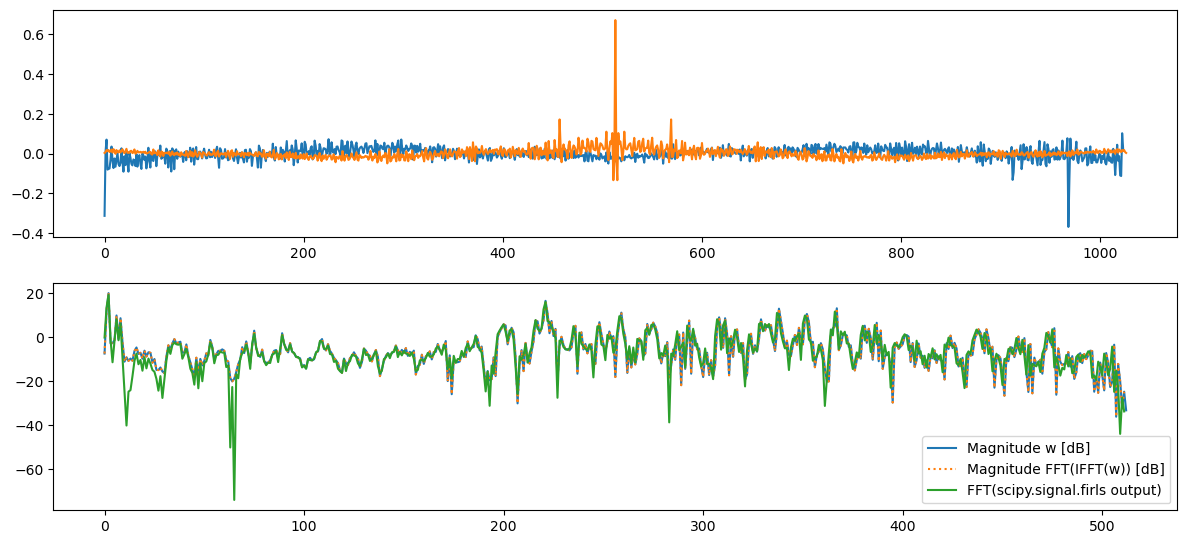

In [91]:
# Compare to directly using `IFFT(w)` when `w` is straight out of DANSE
import time

# wForIFFT = np.abs(w) * np.exp(1j * np.angle(np.append(response, 0)))
wForIFFT = w

if wForIFFT.ndim == 1:
    wForIFFT = wForIFFT[:, np.newaxis]
wForIFFT[0, :] = wForIFFT[0, :].real      # Set DC to real value
wForIFFT[-1, :] = wForIFFT[-1, :].real    # Set Nyquist to real value
wfull = np.concatenate((wForIFFT, np.flip(wForIFFT[:-1, :].conj(), axis=0)[:-1, :]), axis=0)
h = np.fft.ifft(wfull, len(wfull), axis=0)
h = np.real_if_close(h)
h = np.squeeze(h)
# h = h[:int(len(h) / 2)]

out = []
for ii in range(len(x)):
    idxEnd = ii
    idxBeg = idxEnd - len(h)
    if idxBeg < 0:
        currChunkx = np.concatenate((np.zeros(len(h) - idxEnd), x[0:idxEnd]))
    else:
        currChunkx = x[idxBeg:idxEnd]
    tmp = sig.convolve(h, currChunkx, mode='valid', method='auto')
    out.append(tmp[-1])
out = np.array(out)

# plt.plot(x, label='before filtering')
# plt.plot(out, label='after filtering')
# plt.legend()

if 0:
    import simpleaudio as sa
    audio_array = x * 32767 / max(abs(x))
    audio_array = audio_array.astype(np.int16)
    sa.play_buffer(audio_array,1,2,fs)
    time.sleep(T)
    audio_array = out * 32767 / max(abs(out))
    audio_array = audio_array.astype(np.int16)
    sa.play_buffer(audio_array,1,2,fs)

fig, axes = plt.subplots(2,1)
fig.set_size_inches(14.5, 6.5)
axes[0].plot(h, label='IFFT(w)')
axes[0].plot(myfir, label='scipy.signal.firls output')
axes[1].plot(20*np.log10(np.abs(w)), label='Magnitude w [dB]')
axes[1].plot(20*np.log10(np.abs(sig.freqz(h)[1])), ':', label='Magnitude FFT(IFFT(w)) [dB]')
axes[1].plot(20*np.log10(np.abs(response)), label='FFT(scipy.signal.firls output)')
axes[1].legend()